For eric to make a model number vs estimate chart

In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *

import matplotlib.colors as mcolors

from encoding_information.datasets.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as np
import yaml
from led_array.tf_util import prepare_test_dataset
import tensorflow.keras as tfk


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')


2024-10-20 08:18:15.553014: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Opening BSCCM
Opened BSCCM


In [ ]:

experiment_dir = '/home/hpinkard_waller/models/Synthetic_Noise_v10/'
patch_size = 40

mi_estimates_gp = {}
mi_estimates_pixel_cnn = {}
phenotype_nlls = {}
phenotype_marker_indices = {}
for dir_name in os.listdir(experiment_dir):
    # check if complete.txt is in this directory
    if not os.path.exists(os.path.join(experiment_dir, dir_name, 'complete.txt')):
        # print('Skipping', dir_name)
        continue
    if 'Analysis' in dir_name:
        config_file_name = [d for d in os.listdir(os.path.join(experiment_dir, dir_name)) if '.yaml' in d][0]
        config_file_full_path = os.path.join(experiment_dir, dir_name, config_file_name)
        config = yaml.load(open(config_file_full_path, 'r'), Loader=yaml.FullLoader)
        if config['patch_size'] != patch_size:
            continue
        photons_per_pixel = config['data']['synthetic_noise']['photons_per_pixel']
        channel = config['data']['channels'][0]
        replicate = config['metadata']['replicate']
        saving_dir = os.path.join(experiment_dir, dir_name)
        analysis_dir = os.path.join(saving_dir, 'analysis')
        mi_estimate_file = np.load(os.path.join(analysis_dir, [f for f in os.listdir(analysis_dir) if 'mi_estimates' in f][0]))
        # mi_estimates_gp[(channel, photons_per_pixel, replicate)] = mi_estimate_file['mi_gp']


        mi_estimates_pixel_cnn[(channel, photons_per_pixel, replicate)] = (mi_estimate_file['mi_pixel_cnn'], 
                                                                           mi_estimate_file['pixel_cnn_lower_bound'], 
                                                                            mi_estimate_file['pixel_cnn_upper_bound'])
        nll_file = np.load(os.path.join(analysis_dir, [f for f in os.listdir(analysis_dir) if 'phenotyping_nll' in f][0]))
        phenotype_nlls[(channel, photons_per_pixel, replicate)] = nll_file['nlls']
        phenotype_marker_indices[(channel, photons_per_pixel, replicate)] = nll_file['marker_indices']

        # print the channel, photons and mi_gp
        print(channel, photons_per_pixel, mi_estimates_pixel_cnn[(channel, photons_per_pixel, replicate)])    



In [4]:
import numpy as np

# Initialize an empty dictionary to hold the reorganized data
reorganized_data = {}

# Iterate over the keys and values in the original data
for (channel_name, num_photons, replicate_idx), value_tuple in mi_estimates_pixel_cnn.items():
    # If the channel_name is not already a key in reorganized_data, add it
    if channel_name not in reorganized_data:
        reorganized_data[channel_name] = {}
    # If num_photons is not already a key under channel_name, add it
    if num_photons not in reorganized_data[channel_name]:
        reorganized_data[channel_name][num_photons] = []
    # Append the value_tuple to the list under the appropriate keys
    reorganized_data[channel_name][num_photons].append(value_tuple)

# Convert the lists of tuples into Nx3 NumPy arrays
for channel_name in reorganized_data:
    for num_photons in reorganized_data[channel_name]:
        data_list = reorganized_data[channel_name][num_photons]
        n_replicates = len(data_list)
        # Initialize an empty array to hold the data
        data_array = np.zeros((n_replicates, 3))
        for i, value_tuple in enumerate(data_list):
            # Each value_tuple contains three arrays with scalar values
            data_array[i, 0] = value_tuple[0]
            data_array[i, 1] = value_tuple[1]
            data_array[i, 2] = value_tuple[2]
        # Replace the list with the NumPy array
        reorganized_data[channel_name][num_photons] = data_array

# Now, reorganized_data is your nested dictionary with Nx3 arrays


In [9]:
import numpy as np

# Flatten the nested dictionary
flattened_data = {}
for channel_name, photons_dict in reorganized_data.items():
    for num_photons, data_array in photons_dict.items():
        key = f"{channel_name}_{num_photons}"
        flattened_data[key] = data_array

# Save the flattened data to a .npz file
np.savez('reorganized_data.npz', **flattened_data)

In [13]:
loaded_data.keys()

dict_keys(['DPC_Right', 'Brightfield', 'LED119'])

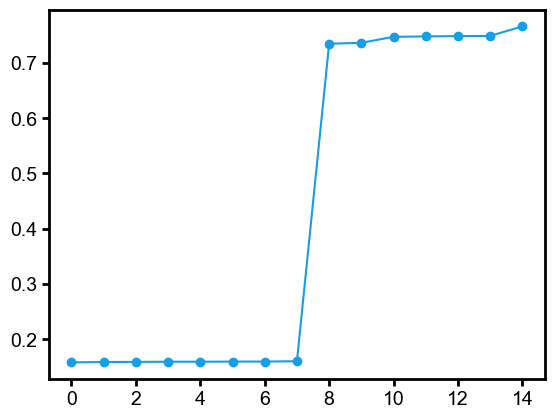

In [11]:
# To load the data back:
loaded_npz = np.load('reorganized_data.npz')

# Reconstruct the nested dictionary
loaded_data = {}
for key in loaded_npz.files:
    channel_name, num_photons = key.rsplit('_', 1)
    num_photons = int(num_photons)
    if channel_name not in loaded_data:
        loaded_data[channel_name] = {}
    loaded_data[channel_name][num_photons] = loaded_npz[key]


# Channels are ['DPC_Right', 'Brightfield', 'LED119']
# Photons are [50, 150, 450]
dpc_right_150_photons_models = loaded_data['DPC_Right'][150]

# N x 3 array with columns for estimates, lower bounds, and upper bounds
estimates, lower_bounds, upper_bounds = dpc_right_150_photons_models.T

# sort the estimates and plot them
sorted_indices = np.argsort(estimates)
sorted_estimates = estimates[sorted_indices]

fig, ax = plt.subplots()
ax.plot(sorted_estimates, '-o')